In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os

In [36]:
NHL_2018_DF = pd.read_csv(r"C:\\Users\\jorda\\Documents\\Concordia Boot Camp\\NHL raw data\\PBP\\nhl_pbp_20182019.csv")

In [37]:
NHL_2018_DF = NHL_2018_DF[['Game_Id','Date','Ev_Team','Home_Team','Event', 'p1_ID', 'Period','Home_Goalie_Id','Away_Goalie_Id','Seconds_Elapsed','Strength','Ev_Zone','Type','xC','yC']] # drop columns I dont need
NHL_2018_DF = NHL_2018_DF[NHL_2018_DF['Event'].isin(['SHOT','GOAL','MISS','FAC','HIT','TAKE', 'GIVE'])] # drop events I dont need (reduce rows)
NHL_2018_DF = NHL_2018_DF[NHL_2018_DF['Strength'].isin(['3x3','3x4','3x5','4x3','4x4','4x5','5x3','5x4','5x5','6x5','5x6'])]
NHL_2018_DF = NHL_2018_DF[NHL_2018_DF['Period']!=5] # no shootouts
                                                                            
#NHL_2018_DF.loc[NHL_2018_DF['Event'] == 'BLOCK', 'Ev_Zone'] = 'Off' #shots that are blocked always labelled as defensive zone. This is wrong.

NHL_2018_DF['Event -1'] = NHL_2018_DF['Event'].shift(1)
NHL_2018_DF['Ev_Team -1'] = NHL_2018_DF['Ev_Team'].shift(1)
NHL_2018_DF['Ev_Zone -1'] = NHL_2018_DF['Ev_Zone'].shift(1)
NHL_2018_DF['xC -1'] = NHL_2018_DF['xC'].shift(1)
NHL_2018_DF['yC -1'] = NHL_2018_DF['yC'].shift(1)
NHL_2018_DF['Seconds_Elapsed -1'] = NHL_2018_DF['Seconds_Elapsed'].shift(1)
NHL_2018_DF['Time_Diff'] = NHL_2018_DF['Seconds_Elapsed'] - NHL_2018_DF['Seconds_Elapsed -1']
#feature engineering will include details on events leading to the shot. Sequencing required.
NHL_2018_DF = NHL_2018_DF.fillna(0)
NHL_2018_DF

,Game_Id,Date,Ev_Team,Home_Team,Event,p1_ID,Period,Home_Goalie_Id,Away_Goalie_Id,Seconds_Elapsed,...,Type,xC,yC,Event -1,Ev_Team -1,Ev_Zone -1,xC -1,yC -1,Seconds_Elapsed -1,Time_Diff
1,20001,2018-10-03,MTL,TOR,FAC,8477503.0,1,8475883.0,8471679.0,0,...,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0
2,20001,2018-10-03,MTL,TOR,SHOT,8477476.0,1,8475883.0,8471679.0,29,...,BACKHAND,78.0,-19.0,FAC,MTL,Neu,0.0,0.0,0.0,29.0
3,20001,2018-10-03,TOR,TOR,SHOT,8476853.0,1,8475883.0,8471679.0,49,...,SNAP SHOT,-37.0,-10.0,SHOT,MTL,Off,78.0,-19.0,29.0,20.0
4,20001,2018-10-03,MTL,TOR,SHOT,8475848.0,1,8475883.0,8471679.0,60,...,WRIST SHOT,47.0,-23.0,SHOT,TOR,Off,-37.0,-10.0,49.0,11.0
6,20001,2018-10-03,TOR,TOR,FAC,8475172.0,1,8475883.0,8471679.0,61,...,0,69.0,-22.0,SHOT,MTL,Off,47.0,-23.0,60.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433392,30417,2019-06-12,STL,BOS,FAC,8475098.0,3,0.0,8476412.0,1070,...,0,0.0,0.0,GOAL,BOS,Off,44.0,24.0,1070.0,0.0
433395,30417,2019-06-12,STL,BOS,FAC,8475158.0,3,0.0,8476412.0,1126,...,0,69.0,-22.0,FAC,STL,Neu,0.0,0.0,1070.0,56.0
433397,30417,2019-06-12,BOS,BOS,FAC,8471276.0,3,0.0,8476412.0,1147,...,0,20.0,22.0,FAC,STL,Def,69.0,-22.0,1126.0,21.0
433398,30417,2019-06-12,BOS,BOS,HIT,8476792.0,3,0.0,8476412.0,1165,...,0,48.0,38.0,FAC,BOS,Neu,20.0,22.0,1147.0,18.0


In [38]:
player_handedness_df = pd.read_csv(r"C:\Users\jorda\Documents\Concordia Boot Camp\Lectures\Player_Bios.csv")
player_handedness_df = player_handedness_df[['Player_ID','Handedness']]
NHL_2018_DF = pd.merge(NHL_2018_DF, player_handedness_df,  how='left', left_on=['p1_ID'], right_on = ['Player_ID'])
NHL_2018_DF = NHL_2018_DF.drop('Player_ID', axis=1)


In [39]:
# Making variables with sequencing.

NHL_2018_DF['Is_Rebound'] = NHL_2018_DF['Event'].isin(['SHOT','GOAL','MISS']) & (NHL_2018_DF['Event -1'].str.contains('SHOT')) & (NHL_2018_DF['Ev_Team']==NHL_2018_DF['Ev_Team -1']) & (NHL_2018_DF['Time_Diff']<=3)
NHL_2018_DF['Is_Flurry'] = NHL_2018_DF['Event'].isin(['SHOT','GOAL','MISS']) & (NHL_2018_DF['Is_Rebound']==1) & (NHL_2018_DF['Ev_Team']==NHL_2018_DF['Ev_Team -1']) & (NHL_2018_DF['Time_Diff']<=2)


NHL_2018_DF['Off_Rush_team'] = NHL_2018_DF['Event'].isin(['SHOT','GOAL','MISS']) & NHL_2018_DF['Event -1'].isin(['SHOT','GOAL','MISS','FAC','HIT','TAKE','GIVE']) & NHL_2018_DF['Ev_Zone -1'].isin(['Def','Neu']) & (NHL_2018_DF['Ev_Team']==NHL_2018_DF['Ev_Team -1']) & (NHL_2018_DF['Time_Diff']<=8) 
NHL_2018_DF['Off_Rush_opp'] = NHL_2018_DF['Event'].isin(['SHOT','GOAL','MISS']) & NHL_2018_DF['Event -1'].isin(['SHOT','GOAL','MISS','FAC','HIT','TAKE','GIVE']) & NHL_2018_DF['Ev_Zone -1'].isin(['Off','Neu']) & (NHL_2018_DF['Ev_Team']!=NHL_2018_DF['Ev_Team -1']) & (NHL_2018_DF['Time_Diff']<=8) 
NHL_2018_DF['Off_Rush'] = (NHL_2018_DF['Off_Rush_team']==True) | (NHL_2018_DF['Off_Rush_opp']==True)
NHL_2018_DF = NHL_2018_DF.drop('Off_Rush_team', axis=1)
NHL_2018_DF = NHL_2018_DF.drop('Off_Rush_opp', axis=1)
# I am just looking for proof that the puck was not in the offensive zone. so I look for both past events from same team and opposing team.


NHL_2018_DF['Off_FO_Win'] = NHL_2018_DF['Event'].isin(['SHOT','GOAL','MISS']) & (NHL_2018_DF['Event -1'].str.contains('FAC')) & (NHL_2018_DF['Ev_Team']==NHL_2018_DF['Ev_Team -1']) & (NHL_2018_DF['Time_Diff']<=5)
NHL_2018_DF['Off_Takeaway'] = NHL_2018_DF['Event'].isin(['SHOT','GOAL','MISS']) & (NHL_2018_DF['Event -1'].str.contains('TAKE')) & (NHL_2018_DF['Ev_Team']==NHL_2018_DF['Ev_Team -1']) & (NHL_2018_DF['Time_Diff']<=5)
NHL_2018_DF['Off_Giveaway'] = NHL_2018_DF['Event'].isin(['SHOT','GOAL','MISS']) & (NHL_2018_DF['Event -1'].str.contains('GIVE')) & (NHL_2018_DF['Ev_Team']!=NHL_2018_DF['Ev_Team -1']) & (NHL_2018_DF['Time_Diff']<=5)
# this is the last of the sequence metrics. Sequence metrics try to take some of the context from before the shot into consideration.

NHL_2018_DF['empty_net_home'] = NHL_2018_DF['Event'].isin(['SHOT','GOAL','MISS']) & (NHL_2018_DF['Ev_Team']==NHL_2018_DF['Home_Team'])  & (NHL_2018_DF['Away_Goalie_Id']==0)
NHL_2018_DF['empty_net_away'] = NHL_2018_DF['Event'].isin(['SHOT','GOAL','MISS']) & (NHL_2018_DF['Ev_Team']!=NHL_2018_DF['Home_Team'])  & (NHL_2018_DF['Home_Goalie_Id']==0)
NHL_2018_DF['empty_net_shot'] = (NHL_2018_DF['empty_net_home']==True) | (NHL_2018_DF['empty_net_away']==True)
NHL_2018_DF = NHL_2018_DF.drop('empty_net_home', axis=1)
NHL_2018_DF = NHL_2018_DF.drop('empty_net_away', axis=1)

NHL_2018_DF['Even_Strength'] = NHL_2018_DF['Strength'].isin(['3x3','4x4','5x5'])
NHL_2018_DF['Power_Play'] = NHL_2018_DF['Strength'].isin(['5x4','5x3','4x3'])
NHL_2018_DF['Short_Handed'] = NHL_2018_DF['Strength'].isin(['3x4','3x5','4x5'])
NHL_2018_DF['Game_Seconds'] = (NHL_2018_DF['Period']-1)*2000 + NHL_2018_DF['Seconds_Elapsed']
NHL_2018_DF.columns

Index(['Game_Id', 'Date', 'Ev_Team', 'Home_Team', 'Event', 'p1_ID', 'Period',
       'Home_Goalie_Id', 'Away_Goalie_Id', 'Seconds_Elapsed', 'Strength',
       'Ev_Zone', 'Type', 'xC', 'yC', 'Event -1', 'Ev_Team -1', 'Ev_Zone -1',
       'xC -1', 'yC -1', 'Seconds_Elapsed -1', 'Time_Diff', 'Handedness',
       'Is_Rebound', 'Is_Flurry', 'Off_Rush', 'Off_FO_Win', 'Off_Takeaway',
       'Off_Giveaway', 'empty_net_shot', 'Even_Strength', 'Power_Play',
       'Short_Handed', 'Game_Seconds'],
      dtype='object')

In [40]:
# Convert booleans into 1 or 0 integers.
NHL_2018_DF = NHL_2018_DF[NHL_2018_DF['Event'].isin(['SHOT','GOAL','MISS'])] #now that sequencing is done I only need my rows with shots.
to_numeric_list = ['Is_Rebound','Is_Flurry','Off_Rush','Off_FO_Win','Off_Takeaway','Off_Giveaway','empty_net_shot','Even_Strength','Power_Play','Short_Handed']

for i in to_numeric_list:
    NHL_2018_DF[f'{i}'] = NHL_2018_DF[f'{i}'].astype(int) #convert booleans to numeric
    
shot_type_df = pd.get_dummies(NHL_2018_DF['Type']) #making categorical variables from the shot types.

NHL_2018_DF = pd.concat([NHL_2018_DF.reset_index(drop=True),shot_type_df.reset_index(drop=True)], axis=1)

NHL_2018_DF['Is_Goal'] = NHL_2018_DF['Event'].isin(['GOAL']) # our Y variable
NHL_2018_DF = NHL_2018_DF[['Game_Id','Date','Period','Seconds_Elapsed','Game_Seconds','xC','yC', 'xC -1', 'yC -1', 'Time_Diff', 'Is_Rebound','Is_Flurry','Off_Rush','Off_FO_Win','Off_Takeaway','Off_Giveaway','BACKHAND','DEFLECTED','SLAP SHOT','SNAP SHOT','TIP-IN','WRAP-AROUND','WRIST SHOT','Even_Strength','Power_Play','Short_Handed', 'Handedness']]


In [41]:
# Since I will be making distance to the net variable, I need to artificially make it so all shots occur on the same side of the ice. This is so I can assume the position of 1 net when calculating.
NHL_2018_DF['xC_adj'] = 0
NHL_2018_DF['yC_adj'] = 0

for i in NHL_2018_DF.index:
    if NHL_2018_DF.at[i, 'xC']>0:
        NHL_2018_DF.at[i, 'xC_adj'] = NHL_2018_DF.at[i, 'xC']
        NHL_2018_DF.at[i, 'yC_adj'] = NHL_2018_DF.at[i, 'yC']
    else:
        NHL_2018_DF.at[i, 'xC_adj'] = NHL_2018_DF.at[i, 'xC']*(-1)
        NHL_2018_DF.at[i, 'yC_adj'] = NHL_2018_DF.at[i, 'yC']*(-1)

NHL_2018_DF['xC_adj -1'] = NHL_2018_DF['xC_adj'].shift(1)
NHL_2018_DF['yC_adj -1'] = NHL_2018_DF['yC_adj'].shift(1)        
NHL_2018_DF = NHL_2018_DF.fillna(0)

NHL_2018_DF
# adjusting x/y coordinates so all shots appear to happen on the same side of the ice. this will massively simplify calculating distance and angle from the net.

,Game_Id,Date,Period,Seconds_Elapsed,Game_Seconds,xC,yC,xC -1,yC -1,Time_Diff,...,WRAP-AROUND,WRIST SHOT,Even_Strength,Power_Play,Short_Handed,Handedness,xC_adj,yC_adj,xC_adj -1,yC_adj -1
0,20001,2018-10-03,1,29,29,78.0,-19.0,0.0,0.0,29.0,...,0,0,1,0,0,Left,78,-19,0.0,0.0
1,20001,2018-10-03,1,49,49,-37.0,-10.0,78.0,-19.0,20.0,...,0,0,1,0,0,Left,37,10,78.0,-19.0
2,20001,2018-10-03,1,60,60,47.0,-23.0,-37.0,-10.0,11.0,...,0,1,1,0,0,Right,47,-23,37.0,10.0
3,20001,2018-10-03,1,229,229,73.0,22.0,48.0,39.0,24.0,...,0,0,1,0,0,Left,73,22,47.0,-23.0
4,20001,2018-10-03,1,234,234,53.0,14.0,73.0,22.0,5.0,...,0,0,1,0,0,Right,53,14,73.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117699,30417,2019-06-12,3,955,4955,-65.0,-4.0,-69.0,7.0,4.0,...,0,0,1,0,0,Left,65,4,69.0,-7.0
117700,30417,2019-06-12,3,1010,5010,42.0,3.0,-69.0,-22.0,55.0,...,0,1,1,0,0,Left,42,3,65.0,4.0
117701,30417,2019-06-12,3,1025,5025,57.0,-13.0,69.0,-22.0,15.0,...,0,0,1,0,0,Right,57,-13,42.0,3.0
117702,30417,2019-06-12,3,1070,5070,44.0,24.0,45.0,-6.0,4.0,...,0,1,1,0,0,Left,44,24,57.0,-13.0


In [51]:
NHL_2018_DF['Strong_Side_Shot'] = (NHL_2018_DF['yC_adj']>=0) & (NHL_2018_DF['Handedness']=='Left') | (NHL_2018_DF['yC_adj']<=0) & (NHL_2018_DF['Handedness']=='Right')


NHL_2018_DF['yC_adj'] = NHL_2018_DF['yC_adj'].astype(float)
NHL_2018_DF['xC_adj'] = NHL_2018_DF['xC_adj'].astype(float)
NHL_2018_DF.head(20)

,Game_Id,Date,Period,Seconds_Elapsed,Game_Seconds,xC,yC,xC -1,yC -1,Time_Diff,...,Power_Play,Short_Handed,Handedness,xC_adj,yC_adj,xC_adj -1,yC_adj -1,Strong_Side_Shot_L,Strong_Side_Shot_R,Strong_Side_Shot
0,20001,2018-10-03,1,29,29,78.0,-19.0,0.0,0.0,29.0,...,0,0,Left,78.0,-19.0,0.0,0.0,False,False,False
1,20001,2018-10-03,1,49,49,-37.0,-10.0,78.0,-19.0,20.0,...,0,0,Left,37.0,10.0,78.0,-19.0,True,False,True
2,20001,2018-10-03,1,60,60,47.0,-23.0,-37.0,-10.0,11.0,...,0,0,Right,47.0,-23.0,37.0,10.0,True,True,True
3,20001,2018-10-03,1,229,229,73.0,22.0,48.0,39.0,24.0,...,0,0,Left,73.0,22.0,47.0,-23.0,True,False,True
4,20001,2018-10-03,1,234,234,53.0,14.0,73.0,22.0,5.0,...,0,0,Right,53.0,14.0,73.0,22.0,False,False,False
5,20001,2018-10-03,1,241,241,81.0,-4.0,84.0,38.0,5.0,...,0,0,Right,81.0,-4.0,53.0,14.0,True,True,True
6,20001,2018-10-03,1,246,246,77.0,-2.0,81.0,-4.0,5.0,...,0,0,Left,77.0,-2.0,81.0,-4.0,False,False,False
7,20001,2018-10-03,1,246,246,80.0,1.0,77.0,-2.0,0.0,...,0,0,Left,80.0,1.0,77.0,-2.0,True,False,True
8,20001,2018-10-03,1,337,337,-67.0,4.0,-83.0,39.0,43.0,...,0,0,Right,67.0,-4.0,80.0,1.0,True,True,True
9,20001,2018-10-03,1,341,341,-75.0,-8.0,-67.0,4.0,4.0,...,0,0,Left,75.0,8.0,67.0,-4.0,True,False,True


In [48]:
#Making shot distance and shot angle variables.

NHL_2018_DF['Shot_Distance'] = 0
NHL_2018_DF['Shot_Angle'] = 0
NHL_2018_DF['last_event_dist'] = 0

for i in NHL_2018_DF.index:
    NHL_2018_DF.at[i, 'Shot_Distance'] = math.sqrt((89-NHL_2018_DF.at[i, 'xC_adj'])**2 + NHL_2018_DF.at[i, 'yC_adj']**2)
    NHL_2018_DF.at[i, 'last_event_dist'] = math.sqrt((NHL_2018_DF.at[i, 'xC -1'] - NHL_2018_DF.at[i, 'xC'])**2 + (NHL_2018_DF.at[i, 'yC -1'] - NHL_2018_DF.at[i, 'yC'])**2)

#NHL_2018_DF['Shot_Angle'] = np.tan(abs(NHL_2018_DF['yC_adj']), abs(NHL_2018_DF['xC_adj']-89))
NHL_2018_DF['Shot_Angle'] = np.degrees(np.arctan2(abs(NHL_2018_DF['yC_adj']), abs(NHL_2018_DF['xC_adj'] - 89)))
NHL_2018_DF['dist_per_sec_last_event'] = NHL_2018_DF['last_event_dist']/NHL_2018_DF['Time_Diff']
NHL_2018_DF.columns

Index(['Game_Id', 'Date', 'Period', 'Seconds_Elapsed', 'Game_Seconds', 'xC',
       'yC', 'xC -1', 'yC -1', 'Time_Diff', 'Is_Rebound', 'Is_Flurry',
       'Off_Rush', 'Off_FO_Win', 'Off_Takeaway', 'Off_Giveaway', 'BACKHAND',
       'DEFLECTED', 'SLAP SHOT', 'SNAP SHOT', 'TIP-IN', 'WRAP-AROUND',
       'WRIST SHOT', 'Even_Strength', 'Power_Play', 'Short_Handed', 'xC_adj',
       'yC_adj', 'xC_adj -1', 'yC_adj -1', 'Shot_Distance', 'Shot_Angle',
       'last_event_dist', 'dist_per_sec_last_event'],
      dtype='object')

In [49]:
NHL_2018_DF['Royal_Road'] = (NHL_2018_DF['yC_adj -1']<0) & (NHL_2018_DF['yC_adj']>0) & (NHL_2018_DF['Time_Diff']<5) | (NHL_2018_DF['yC_adj -1']>0) & (NHL_2018_DF['yC_adj']<0) & (NHL_2018_DF['Time_Diff']<5)


,Game_Id,Date,Period,Seconds_Elapsed,Game_Seconds,xC,yC,xC -1,yC -1,Time_Diff,...,Short_Handed,xC_adj,yC_adj,xC_adj -1,yC_adj -1,Shot_Distance,Shot_Angle,last_event_dist,dist_per_sec_last_event,Royal_Road
7,20001,2018-10-03,1,246,246,80.0,1.0,77.0,-2.0,0.0,...,0,80.0,1.0,77.0,-2.0,9.055385,6.340192,4.242641,inf,True
88,20001,2018-10-03,3,967,4967,76.0,0.0,58.0,-5.0,2.0,...,0,76.0,0.0,58.0,-5.0,13.000000,0.000000,18.681542,9.340771,False
217,20003,2018-10-03,2,308,2308,82.0,0.0,79.0,2.0,1.0,...,0,82.0,0.0,79.0,2.0,7.000000,0.000000,3.605551,3.605551,False
238,20003,2018-10-03,3,140,4140,-84.0,-8.0,-77.0,3.0,1.0,...,0,84.0,8.0,77.0,-3.0,9.433981,57.994617,13.038405,13.038405,True
240,20003,2018-10-03,3,167,4167,84.0,-8.0,71.0,-19.0,1.0,...,0,84.0,-8.0,71.0,-19.0,9.433981,57.994617,17.029386,17.029386,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117538,30415,2019-06-06,3,419,4419,86.0,5.0,84.0,7.0,1.0,...,0,86.0,5.0,84.0,7.0,5.830952,59.036243,2.828427,2.828427,False
117567,30416,2019-06-09,1,520,520,-73.0,25.0,-77.0,6.0,2.0,...,1,73.0,-25.0,77.0,-6.0,29.681644,57.380757,19.416488,9.708244,False
117571,30416,2019-06-09,1,631,631,-84.0,2.0,-74.0,1.0,1.0,...,0,84.0,-2.0,74.0,-1.0,5.385165,21.801409,10.049876,10.049876,False
117596,30416,2019-06-09,2,595,2595,-52.0,-20.0,-36.0,21.0,2.0,...,0,52.0,20.0,36.0,-21.0,42.059482,28.393019,44.011362,22.005681,True


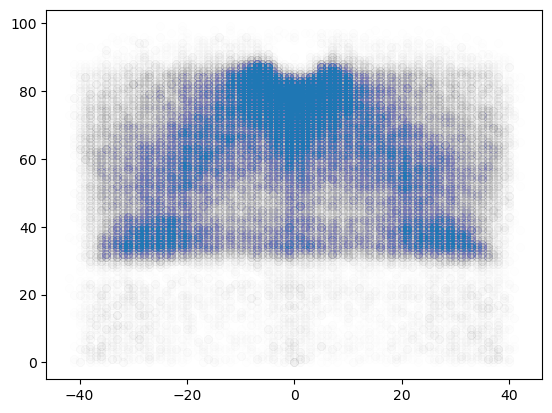

In [196]:
plt.scatter(NHL_2018_DF['yC_adj'],NHL_2018_DF['xC_adj'], alpha=0.002)

In [61]:
#All the above work is to check each segment of the code. This function is what I would consider my "Real" code as it is more clean and what I actually use when making the dataset for xG model.

def xG_data_setup(path):

    NHL_temp_DF = pd.read_csv(path)

    season_id = NHL_temp_DF.at[0, 'Date'][:4]  #checks the first game for the year. so if season is 2018-2019, it will see the first game is on 2018. I will use this year of the first game as season id (with the value being the year the season started in).
    #the data scrapper returns a CSV that is already in order of ascending date, otherwise I would of used a sort before.
                
    NHL_temp_DF = NHL_temp_DF[['Game_Id','Date','Ev_Team','p1_ID','Home_Team','Event','Period','Home_Goalie_Id','Away_Goalie_Id','Seconds_Elapsed','Strength','Ev_Zone','Type','xC','yC']] # drop columns I dont need
    NHL_temp_DF = NHL_temp_DF[NHL_temp_DF['Event'].isin(['SHOT','GOAL','MISS','FAC','HIT','TAKE', 'GIVE'])] # drop events I dont need (reduce rows)
    NHL_temp_DF = NHL_temp_DF[NHL_temp_DF['Strength'].isin(['3x3','3x4','3x5','4x3','4x4','4x5','5x3','5x4','5x5','6x5','5x6'])] #remove bogus rows with bad manpower situation.
    NHL_temp_DF = NHL_temp_DF[NHL_temp_DF['Period']!=5] # no shootouts                                                                     
   # NHL_temp_DF.loc[NHL_temp_DF['Event'] == 'BLOCK', 'Ev_Zone'] = 'Off' #shots that are blocked always labelled as defensive zone. This is wrong.
   
    NHL_temp_DF['Event -1'] = NHL_temp_DF['Event'].shift(1)
    NHL_temp_DF['Ev_Team -1'] = NHL_temp_DF['Ev_Team'].shift(1)
    NHL_temp_DF['Ev_Zone -1'] = NHL_temp_DF['Ev_Zone'].shift(1)
    NHL_temp_DF['xC -1'] = NHL_temp_DF['xC'].shift(1)
    NHL_temp_DF['yC -1'] = NHL_temp_DF['yC'].shift(1)
    NHL_temp_DF['Seconds_Elapsed -1'] = NHL_temp_DF['Seconds_Elapsed'].shift(1)
    NHL_temp_DF['Time_Diff'] = NHL_temp_DF['Seconds_Elapsed'] - NHL_temp_DF['Seconds_Elapsed -1']
    NHL_temp_DF['Time_Diff'] = NHL_temp_DF['Time_Diff']+0.1
    #laging data for sequential features.
    
    player_handedness_df = pd.read_csv(r"C:\Users\jorda\Documents\Concordia Boot Camp\Lectures\Player_Bios.csv")
    player_handedness_df = player_handedness_df[['Player_ID','Handedness']]
    NHL_temp_DF = pd.merge(NHL_temp_DF, player_handedness_df,  how='left', left_on=['p1_ID'], right_on = ['Player_ID'])
    NHL_temp_DF = NHL_temp_DF.drop('Player_ID', axis=1)
    
    NHL_temp_DF = NHL_temp_DF.fillna(0) 
    
    NHL_temp_DF['Is_Rebound'] = NHL_temp_DF['Event'].isin(['SHOT','GOAL','MISS']) & (NHL_temp_DF['Event -1'].str.contains('SHOT')) & (NHL_temp_DF['Ev_Team']==NHL_temp_DF['Ev_Team -1']) & (NHL_temp_DF['Time_Diff']<=3)
    NHL_temp_DF['Is_Flurry'] = NHL_temp_DF['Event'].isin(['SHOT','GOAL','MISS']) & (NHL_temp_DF['Is_Rebound']==1) & (NHL_temp_DF['Ev_Team']==NHL_temp_DF['Ev_Team -1']) & (NHL_temp_DF['Time_Diff']<=2)
    NHL_temp_DF['Off_Rush_team'] = NHL_temp_DF['Event'].isin(['SHOT','GOAL','MISS']) & NHL_temp_DF['Event -1'].isin(['SHOT','GOAL','MISS','FAC','HIT','TAKE','GIVE']) & NHL_temp_DF['Ev_Zone -1'].isin(['Def','Neu']) & (NHL_temp_DF['Ev_Team']==NHL_temp_DF['Ev_Team -1']) & (NHL_temp_DF['Time_Diff']<=15) 
    NHL_temp_DF['Off_Rush_opp'] = NHL_temp_DF['Event'].isin(['SHOT','GOAL','MISS']) & NHL_temp_DF['Event -1'].isin(['SHOT','GOAL','MISS','FAC','HIT','TAKE','GIVE']) & NHL_temp_DF['Ev_Zone -1'].isin(['Off','Neu']) & (NHL_temp_DF['Ev_Team']!=NHL_temp_DF['Ev_Team -1']) & (NHL_temp_DF['Time_Diff']<=15) 
    NHL_temp_DF['Off_Rush'] = (NHL_temp_DF['Off_Rush_team']==True) | (NHL_temp_DF['Off_Rush_opp']==True)
    NHL_temp_DF = NHL_temp_DF.drop('Off_Rush_team', axis=1)
    NHL_temp_DF = NHL_temp_DF.drop('Off_Rush_opp', axis=1)
    NHL_temp_DF['Off_FO_Win'] = NHL_temp_DF['Event'].isin(['SHOT','GOAL','MISS']) & (NHL_temp_DF['Event -1'].str.contains('FAC')) & (NHL_temp_DF['Ev_Team']==NHL_temp_DF['Ev_Team -1']) & (NHL_temp_DF['Time_Diff']<=8)
    NHL_temp_DF['Off_Takeaway'] = NHL_temp_DF['Event'].isin(['SHOT','GOAL','MISS']) & (NHL_temp_DF['Event -1'].str.contains('TAKE')) & (NHL_temp_DF['Ev_Team']==NHL_temp_DF['Ev_Team -1']) & (NHL_temp_DF['Time_Diff']<=8)
    NHL_temp_DF['Off_Giveaway'] = NHL_temp_DF['Event'].isin(['SHOT','GOAL','MISS']) & (NHL_temp_DF['Event -1'].str.contains('GIVE')) & (NHL_temp_DF['Ev_Team']!=NHL_temp_DF['Ev_Team -1']) & (NHL_temp_DF['Time_Diff']<=8)
                
    NHL_temp_DF['empty_net_home'] = NHL_temp_DF['Event'].isin(['SHOT','GOAL','MISS']) & (NHL_temp_DF['Ev_Team']==NHL_temp_DF['Home_Team'])  & (NHL_temp_DF['Away_Goalie_Id']==0)
    NHL_temp_DF['empty_net_away'] = NHL_temp_DF['Event'].isin(['SHOT','GOAL','MISS']) & (NHL_temp_DF['Ev_Team']!=NHL_temp_DF['Home_Team'])  & (NHL_temp_DF['Home_Goalie_Id']==0)
    NHL_temp_DF['empty_net_shot'] = (NHL_temp_DF['empty_net_home']==True) | (NHL_temp_DF['empty_net_away']==True)
    NHL_temp_DF = NHL_temp_DF.drop('empty_net_home', axis=1)
    NHL_temp_DF = NHL_temp_DF.drop('empty_net_away', axis=1)
    NHL_temp_DF['Even_Strength'] = NHL_temp_DF['Strength'].isin(['3x3','4x4','5x5'])
    NHL_temp_DF['Power_Play'] = NHL_temp_DF['Strength'].isin(['5x4','5x3','4x3'])
    NHL_temp_DF['Short_Handed'] = NHL_temp_DF['Strength'].isin(['3x4','3x5','4x5'])
    NHL_temp_DF['Game_Seconds'] = (NHL_temp_DF['Period']-1)*2000 + NHL_temp_DF['Seconds_Elapsed']
    # Sequence metrics try to take some of the context from before the shot into consideration.
    
    NHL_temp_DF['Is_Goal'] = NHL_temp_DF['Event'].isin(['GOAL']) # our Y variable

    NHL_temp_DF = NHL_temp_DF[NHL_temp_DF['Event'].isin(['SHOT','GOAL','MISS'])] #now that sequencing is done I only need my rows with shots.
    
    to_numeric_list = ['Is_Goal','Is_Rebound','Is_Flurry','Off_Rush','Off_FO_Win','Off_Takeaway','Off_Giveaway','empty_net_shot','Even_Strength','Power_Play','Short_Handed'] # sequential metrics I want to convert to numeric.
    
    for i in to_numeric_list:
        NHL_temp_DF[f'{i}'] = NHL_temp_DF[f'{i}'].astype(int) #convert sequence metrics booleans to numeric
    
    shot_type_df = pd.get_dummies(NHL_temp_DF['Type']) #making categorical variables from the shot types.
    NHL_temp_DF = pd.concat([NHL_temp_DF.reset_index(drop=True),shot_type_df.reset_index(drop=True)], axis=1)

    NHL_temp_DF = NHL_temp_DF[['Game_Id','Date','Period','Seconds_Elapsed','Game_Seconds','p1_ID','Event','xC','yC', 'xC -1', 'yC -1', 'Time_Diff', 'Is_Rebound','Is_Flurry','Off_Rush','Off_FO_Win','Off_Takeaway','Off_Giveaway','BACKHAND','DEFLECTED','SLAP SHOT','SNAP SHOT','TIP-IN','WRAP-AROUND','WRIST SHOT','Even_Strength','Power_Play','Short_Handed','Is_Goal','empty_net_shot', 'Handedness']]

    #reducing columns again to save memory.
    
    NHL_temp_DF['xC_adj'] = 0
    NHL_temp_DF['yC_adj'] = 0

    for i in NHL_temp_DF.index: #here we are making sure that all shots appear on the same side of the ice. This is so we can use 1 x/y point as the net. instead of having to process each side of the ice separately.
        if NHL_temp_DF.at[i, 'xC']>0:
            NHL_temp_DF.at[i, 'xC_adj'] = NHL_temp_DF.at[i, 'xC']
            NHL_temp_DF.at[i, 'yC_adj'] = NHL_temp_DF.at[i, 'yC']
        else:
            NHL_temp_DF.at[i, 'xC_adj'] = NHL_temp_DF.at[i, 'xC']*(-1)
            NHL_temp_DF.at[i, 'yC_adj'] = NHL_temp_DF.at[i, 'yC']*(-1)
    
    NHL_temp_DF['xC_adj -1'] = NHL_temp_DF['xC_adj'].shift(1)
    NHL_temp_DF['yC_adj -1'] = NHL_temp_DF['yC_adj'].shift(1)
    
    NHL_temp_DF['Strong_Side_Shot'] = (NHL_temp_DF['yC_adj']>=0) & (NHL_temp_DF['Handedness']=='Left') | (NHL_temp_DF['yC_adj']<=0) & (NHL_temp_DF['Handedness']=='Right')
    NHL_temp_DF['Strong_Side_Shot'] = NHL_temp_DF['Strong_Side_Shot'].astype(int)
    
    NHL_temp_DF['season_id'] = season_id
    
    NHL_temp_DF['Shot_Distance'] = 0
    NHL_temp_DF['Shot_Angle'] = 0

    for i in NHL_temp_DF.index:
        NHL_temp_DF.at[i, 'Shot_Distance'] = math.sqrt((89-NHL_temp_DF.at[i, 'xC_adj'])**2 + NHL_temp_DF.at[i, 'yC_adj']**2)
        NHL_temp_DF.at[i, 'last_event_dist'] = math.sqrt((NHL_temp_DF.at[i, 'xC -1'] - NHL_temp_DF.at[i, 'xC'])**2 + (NHL_temp_DF.at[i, 'yC -1'] - NHL_temp_DF.at[i, 'yC'])**2)

    NHL_temp_DF['Shot_Angle'] = np.degrees(np.arctan2(abs(NHL_temp_DF['yC_adj']), abs(NHL_temp_DF['xC_adj'] - 89)))
    NHL_temp_DF['dist_per_sec_last_event'] = NHL_temp_DF['last_event_dist']/NHL_temp_DF['Time_Diff']
    NHL_temp_DF['Below_goal_line'] = NHL_temp_DF['xC_adj']>=89.1
    NHL_temp_DF['Below_goal_line'] = NHL_temp_DF['Below_goal_line'].astype(int)
    NHL_temp_DF['Below_goal_line'] = NHL_temp_DF['xC_adj']>=89.1
    NHL_temp_DF['Below_goal_line'] = NHL_temp_DF['Below_goal_line'].astype(int)
    
    NHL_temp_DF['Royal_Road'] = (NHL_temp_DF['yC_adj -1']<0) & (NHL_temp_DF['yC_adj']>0) & (NHL_temp_DF['Time_Diff']<6) | (NHL_temp_DF['yC_adj -1']>0) & (NHL_temp_DF['yC_adj']<0) & (NHL_temp_DF['Time_Diff']<6)
    NHL_temp_DF['Royal_Road'] = NHL_temp_DF['Royal_Road'].astype(int)
    
    
    return NHL_temp_DF

In [62]:
path = r"C:\Users\jorda\Documents\Concordia Boot Camp\NHL raw data\PBP\nhl_pbp_20182019.csv"

In [63]:
NHL_2018_DF = xG_data_setup(path)

NHL_2018_DF #It works for a single season!

,Game_Id,Date,Period,Seconds_Elapsed,Game_Seconds,p1_ID,Event,xC,yC,xC -1,...,xC_adj -1,yC_adj -1,Strong_Side_Shot,season_id,Shot_Distance,Shot_Angle,last_event_dist,dist_per_sec_last_event,Below_goal_line,Royal_Road
0,20001,2018-10-03,1,29,29,8477476.0,SHOT,78.0,-19.0,0.0,...,NaN,NaN,0,2018,21.954498,59.931417,80.280757,2.758789,0,0
1,20001,2018-10-03,1,49,49,8476853.0,SHOT,-37.0,-10.0,78.0,...,78.0,-19.0,1,2018,52.952809,10.885527,115.351636,5.738887,0,0
2,20001,2018-10-03,1,60,60,8475848.0,SHOT,47.0,-23.0,-37.0,...,37.0,10.0,1,2018,47.885280,28.705953,85.000000,7.657658,0,0
3,20001,2018-10-03,1,229,229,8476422.0,MISS,73.0,22.0,48.0,...,47.0,-23.0,1,2018,27.202941,53.972627,30.232433,1.254458,0,0
4,20001,2018-10-03,1,234,234,8475848.0,SHOT,53.0,14.0,73.0,...,73.0,22.0,0,2018,38.626416,21.250506,21.540659,4.223659,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117699,30417,2019-06-12,3,955,4955,8475158.0,SHOT,-65.0,-4.0,-69.0,...,69.0,-7.0,1,2018,24.331050,9.462322,11.704700,2.854805,0,1
117700,30417,2019-06-12,3,1010,5010,8475149.0,SHOT,42.0,3.0,-69.0,...,65.0,4.0,1,2018,47.095647,3.652223,113.780490,2.064982,0,0
117701,30417,2019-06-12,3,1025,5025,8475745.0,MISS,57.0,-13.0,69.0,...,42.0,3.0,1,2018,34.539832,22.109448,15.000000,0.993377,0,0
117702,30417,2019-06-12,3,1070,5070,8476891.0,GOAL,44.0,24.0,45.0,...,57.0,-13.0,1,2018,51.000000,28.072487,30.016662,7.321137,0,1


In [64]:
#here I pull up the raw PBP data that was scrapped.

file_path = r'C:\Users\jorda\Documents\Concordia Boot Camp\NHL raw data\PBP'

file_list = os.listdir(file_path)
File_list_final=[]
for i in file_list:
    File_list_final.append(f'{file_path}\{i}') # Making a list of the files I need to extract+ transform then append to final DF.
File_list_final
#NHL_Shots_DF = pd.DataFrame()

#for i in File_list_final:
#    if i ==0:
#        NHL_Shots_DF = xG_data_setup(i) #for first pass we set up our total DF.
#    else:
#        Season_shots = xG_data_setup(i) #for second+ pass we set up temp DF which we quickly merge onto main DF before moving to next season.
#    pd.concat([NHL_Shots_DF, Season_shots])
    
#NHL_Shots_DF


#This section does not work. The function works on all seasons, so the data per season is good. the concat works when I try to manually combine any 2 seasons.
# only in this function where I attempt to make a 1.5 million row + DF it returns nothing. So I will tackle this issue outside of a function.

['C:\\Users\\jorda\\Documents\\Concordia Boot Camp\\NHL raw data\\PBP\\nhl_pbp_20132014.csv',
 'C:\\Users\\jorda\\Documents\\Concordia Boot Camp\\NHL raw data\\PBP\\nhl_pbp_20142015.csv',
 'C:\\Users\\jorda\\Documents\\Concordia Boot Camp\\NHL raw data\\PBP\\nhl_pbp_20152016.csv',
 'C:\\Users\\jorda\\Documents\\Concordia Boot Camp\\NHL raw data\\PBP\\nhl_pbp_20162017.csv',
 'C:\\Users\\jorda\\Documents\\Concordia Boot Camp\\NHL raw data\\PBP\\nhl_pbp_20172018.csv',
 'C:\\Users\\jorda\\Documents\\Concordia Boot Camp\\NHL raw data\\PBP\\nhl_pbp_20182019.csv',
 'C:\\Users\\jorda\\Documents\\Concordia Boot Camp\\NHL raw data\\PBP\\nhl_pbp_20192020.csv',
 'C:\\Users\\jorda\\Documents\\Concordia Boot Camp\\NHL raw data\\PBP\\nhl_pbp_20202021.csv',
 'C:\\Users\\jorda\\Documents\\Concordia Boot Camp\\NHL raw data\\PBP\\nhl_pbp_20212022.csv',
 'C:\\Users\\jorda\\Documents\\Concordia Boot Camp\\NHL raw data\\PBP\\nhl_pbp_20222023.csv']

In [65]:
print(File_list_final[0])
print(File_list_final[1])
print(File_list_final[2])
print(File_list_final[3])
print(File_list_final[4])
print(File_list_final[5])
print(File_list_final[6])
print(File_list_final[7])
print(File_list_final[8])
print(File_list_final[9])

C:\Users\jorda\Documents\Concordia Boot Camp\NHL raw data\PBP\nhl_pbp_20132014.csv
C:\Users\jorda\Documents\Concordia Boot Camp\NHL raw data\PBP\nhl_pbp_20142015.csv
C:\Users\jorda\Documents\Concordia Boot Camp\NHL raw data\PBP\nhl_pbp_20152016.csv
C:\Users\jorda\Documents\Concordia Boot Camp\NHL raw data\PBP\nhl_pbp_20162017.csv
C:\Users\jorda\Documents\Concordia Boot Camp\NHL raw data\PBP\nhl_pbp_20172018.csv
C:\Users\jorda\Documents\Concordia Boot Camp\NHL raw data\PBP\nhl_pbp_20182019.csv
C:\Users\jorda\Documents\Concordia Boot Camp\NHL raw data\PBP\nhl_pbp_20192020.csv
C:\Users\jorda\Documents\Concordia Boot Camp\NHL raw data\PBP\nhl_pbp_20202021.csv
C:\Users\jorda\Documents\Concordia Boot Camp\NHL raw data\PBP\nhl_pbp_20212022.csv
C:\Users\jorda\Documents\Concordia Boot Camp\NHL raw data\PBP\nhl_pbp_20222023.csv


In [ ]:
# Now to run my function on each season of data

In [66]:
NHL_2013_DF = xG_data_setup(File_list_final[0])

In [67]:
NHL_2014_DF = xG_data_setup(File_list_final[1])

In [68]:
NHL_2015_DF = xG_data_setup(File_list_final[2])

In [69]:
NHL_2016_DF = xG_data_setup(File_list_final[3])

In [70]:
NHL_2017_DF = xG_data_setup(File_list_final[4])

In [71]:
NHL_2018_DF = xG_data_setup(File_list_final[5])

In [72]:
NHL_2019_DF = xG_data_setup(File_list_final[6])

In [73]:
NHL_2020_DF = xG_data_setup(File_list_final[7])

In [74]:
NHL_2021_DF = xG_data_setup(File_list_final[8])

In [75]:
NHL_2022_DF = xG_data_setup(File_list_final[9])

In [76]:
# Now to concatinate into my final dataset.
NHL_ALLSHOTS_DF = pd.concat([NHL_2013_DF,NHL_2014_DF,NHL_2015_DF,NHL_2016_DF,NHL_2017_DF,NHL_2018_DF,NHL_2019_DF,NHL_2020_DF,NHL_2021_DF,NHL_2022_DF])

In [77]:
NHL_ALLSHOTS_DF

,Game_Id,Date,Period,Seconds_Elapsed,Game_Seconds,p1_ID,Event,xC,yC,xC -1,...,xC_adj -1,yC_adj -1,Strong_Side_Shot,season_id,Shot_Distance,Shot_Angle,last_event_dist,dist_per_sec_last_event,Below_goal_line,Royal_Road
0,20001,2013-10-01,1,74.0,74.0,8471742.0,MISS,35.0,-28.0,0.0,...,NaN,NaN,1,2013,60.827625,27.407575,44.821870,0.604884,0,0
1,20001,2013-10-01,1,96.0,96.0,8475848.0,SHOT,-82.0,-22.0,35.0,...,35.0,-28.0,0,2013,23.086793,72.349876,117.153745,5.301074,0,0
2,20001,2013-10-01,1,144.0,144.0,8471504.0,SHOT,-44.0,-5.0,-20.0,...,82.0,22.0,1,2013,45.276926,6.340192,29.410882,2.430651,0,0
3,20001,2013-10-01,1,148.0,148.0,8470324.0,SHOT,-56.0,-38.0,-69.0,...,44.0,5.0,1,2013,50.328918,49.028264,20.615528,6.650170,0,0
4,20001,2013-10-01,1,178.0,178.0,8474037.0,SHOT,55.0,-5.0,51.0,...,56.0,38.0,0,2013,34.365681,8.365886,44.181444,21.038783,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105514,21213,2023-04-01,3,953.0,4953.0,8476913.0,SHOT,83.0,5.0,-44.0,...,44.0,-1.0,1,2022,7.810250,39.805571,127.062977,17.896194,0,0
105515,21213,2023-04-01,3,981.0,4981.0,8476967.0,SHOT,40.0,1.0,69.0,...,83.0,5.0,1,2022,49.010203,1.169139,35.805028,1.321219,0,0
105516,21213,2023-04-01,3,1047.0,5047.0,8475169.0,SHOT,18.0,15.0,20.0,...,40.0,1.0,1,2022,72.567210,11.929322,37.054015,0.626971,0,0
105517,21213,2023-04-01,3,1054.0,5054.0,8475169.0,SHOT,66.0,1.0,18.0,...,18.0,15.0,1,2022,23.021729,2.489553,50.000000,7.042254,0,0


In [78]:
NHL_ALLSHOTS_DF.to_csv('NHL_Shots_2013-2022.csv', index=False)